# Create Binary Classification Network to Predict Near vs Far

This is a first attempt to get a network to predict whether a galaxy is near or far.

Near in this case is a distance <= 5 and far is >= 10. Only data with distance <= 5 or distance >= 10 will be considered, just to simplify the problem.  So it will be a binary classification.

In [1]:
import os.path
import io
import itertools

import numpy as np
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib

from astropy.io import fits
from astropy.table import Table

from decimal import Decimal
import math

from utils import *

directory = '/data/dwarf-galaxies-stamps2/'
info_file = os.path.join(directory, 'stamps2.ecsv')

Using TensorFlow backend.


## User Methods

In [2]:
def get_input(filename):
    """
    Loader function for teh data given a filename
    """
    
    f = fits.open(os.path.join(directory, filename))
    img = f[0].data.transpose((1, 2, 0))[16:-16,16:-16] # move channels to last.
    return img


def get_output(dwarf_table_row, columns):    
    """
    Loader function for the y_true parameters.
    """
    
    return dwarf_table_row['distance'] >= 10

def preprocess_input(image):
    """
    Any preprocessing we want done... none at this point.
    """
    
#     --- Rescale Image
#     --- Rotate Image
#     --- Resize Image
#     --- Flip Image
#     --- PCA etc.
    
    return(image)


## Load the Information File

Going to load the file and then filter on data that has a distance <= 5 or distance >= 10.  As we are going to do a "far" "not far" kind of classification.

And because there are far fewer in the distance <= 5 range, it is going to be even more important to use the probabilities on choosing data.


In [3]:
dwarfs_table = Table.read(info_file, format='ascii.ecsv')
# dwarfs_table = dwarfs_table[(dwarfs_table['distance'] <= 5) | (dwarfs_table['distance'] >= 10)]
dwarfs_table

<Table length=12558>
                      filename                       logmass ... noise_z noise_y
                       str52                         float64 ... float64 float64
---------------------------------------------------- ------- ... ------- -------
stamps2/d14.79_m7.45_re0.35_feh-1.2_age10.0_HSC.fits  7.4485 ...  0.0349  0.0164
stamps2/d12.46_m6.72_re0.44_feh-1.5_age12.6_HSC.fits  6.7190 ...  0.0245  0.0281
 stamps2/d9.81_m8.47_re0.84_feh-1.0_age12.3_HSC.fits  8.4725 ...  0.0251  0.0167
 stamps2/d14.38_m5.08_re0.47_feh-2.0_age7.0_HSC.fits  5.0823 ...  0.0365  0.0319
stamps2/d11.95_m8.55_re1.34_feh-1.0_age13.7_HSC.fits  8.5475 ...  0.0372  0.0224
  stamps2/d9.74_m5.33_re0.46_feh-1.8_age7.7_HSC.fits  5.3289 ...  0.0179  0.0166
stamps2/d10.94_m5.00_re0.95_feh-1.5_age13.2_HSC.fits  5.0040 ...  0.0202  0.0344
stamps2/d12.95_m5.07_re0.21_feh-2.0_age11.4_HSC.fits  5.0731 ...  0.0233  0.0198
 stamps2/d7.03_m6.23_re0.47_feh-1.8_age11.3_HSC.fits  6.2316 ...  0.0374  0.0274
stamps2/d11.57_m5.17_re0.22_feh-2.0_age11.7_HSC.fits  5.1709 ...  0.0338  0.0230
                                                 ...     ... ...     ...     ...
 stamps2/d3.73_m7.66_re0.45_feh-1.2_age13.1_HSC.fits  7.6571 ...  0.0174  0.0350
 stamps2/d10.51_m5.05_re0.19_feh-2.0_age9.7_HSC.fits  5.0504 ...  0.0291  0.0190
stamps2/d10.23_m8.55_re0.72_feh-1.2_age10.8_HSC.fits  8.5462 ...  0.0320  0.0177
stamps2/d11.71_m6.42_re0.63_feh-1.5_age10.1_HSC.fits  6.4168 ...  0.0397  0.0283
 stamps2/d3.68_m5.31_re0.53_feh-2.0_age14.0_HSC.fits  5.3101 ...  0.0324  0.0192
stamps2/d14.93_m5.67_re0.21_feh-2.0_age12.0_HSC.fits  5.6689 ...  0.0299  0.0189
 stamps2/d11.84_m7.86_re0.43_feh-1.2_age8.2_HSC.fits  7.8559 ...  0.0179  0.0350
  stamps2/d4.90_m7.64_re0.43_feh-1.0_age8.7_HSC.fits  7.6398 ...  0.0163  0.0305
stamps2/d14.13_m5.68_re0.35_feh-1.8_age10.2_HSC.fits  5.6786 ...  0.0234  0.0307
stamps2/d11.39_m8.88_re1.23_feh-1.0_age12.0_HSC.fits  8.8764 ...  0.0161  0.0344

## Load the Data into Test and Train

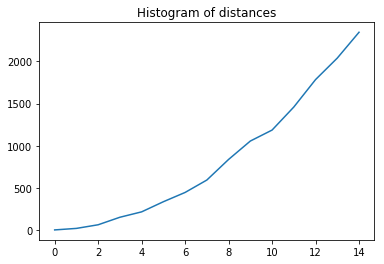

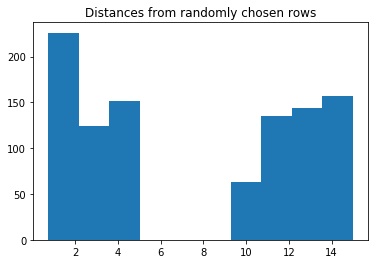

In [4]:
# Get a list of all row indices
indices = range(len(dwarfs_table))

# training indices
counts, bins = np.histogram(dwarfs_table['distance'], np.arange(0, 16))

plt.plot(counts)
plt.title('Histogram of distances')

# Calculate the probability for each point with which we want it chosen.
plookup = (1 / len(counts)) * (1 / counts)
probabilities = np.array([plookup[int(x)] for x in np.floor(dwarfs_table['distance'])])

# Make the probability 0 for ones that we don't want selected,
# and then renormalize so that it sums to 1.
probabilities[ (5 < dwarfs_table['distance']) & (dwarfs_table['distance'] < 10) ] = 0
probabilities = probabilities / np.sum(probabilities)

# As a test we are going to randomly choose 1000 points to make sure that what comes back is a uniform distribution
# of distances.
plt.figure()
out = np.random.choice(dwarfs_table['distance'], 1000, p=probabilities)
plt.hist(out)
plt.title('Distances from randomly chosen rows')

# Now get the training, validation and test indices
training_test_indices = random_subsets(indices, [500, 50, 2000], probabilities=probabilities)
test_indices, validation_indices, training_indices = training_test_indices

## Compile the Neural Network

In [5]:
EPOCHS = 20
BATCH_SIZE = 32

vgg_model = VGG19(weights='imagenet')

# Disassemble layers
ls = [l for l in vgg_model.layers[:-1]]

# Defining new convolutional layer.
# Important: the number of filters should be the same!
# Note: the receiptive field of two 3x3 convolutions is 5x5.
vgg19_input = layers.Input(shape=(224, 224, 5))
new_conv = layers.Conv2D(filters=3,
                        kernel_size=(1, 1),
                        name='5to3',
                        padding='same')

# Now stack everything back
# Note: If you are going to fine tune the model, do not forget to
#       mark other layers as un-trainable

x = vgg19_input
x = new_conv(x)
for i in range(1, len(ls)):
    ls[i].trainable = False
    x = ls[i](x)

dense = layers.Dense(200, activation='relu')
x = dense(x)

predict = layers.Dense(1, activation='sigmoid')
x = predict(x)

# Final touch
model = keras.Model(input=vgg19_input, output=x)

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0808 15:19:11.720090 140096515176192 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 15:19:11.737022 140096515176192 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 15:19:11.739707 140096515176192 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 15:19:11.766088 140096515176192 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 5)       0         
_________________________________________________________________
5to3 (Conv2D)                (None, 224, 224, 3)       18        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________

## Train the Neural Network

In [6]:
EPOCHS = 10
BATCH_SIZE = 32
columns = ['distance'] # though not really needed for near-far

train_generator = image_generator(dwarfs_table, training_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)
validation_generator = image_generator(dwarfs_table, validation_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)
test_generator = image_generator(dwarfs_table, test_indices, columns, get_input, get_output, batch_size=BATCH_SIZE)

steps_per_epoch = len(training_indices)//BATCH_SIZE
validation_steps = len(validation_indices)//BATCH_SIZE

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[])


Epoch 1/10
62/62 [==============================] - 40s 637ms/step - loss: 0.3875 - acc: 0.8916 - val_loss: 0.4587 - val_acc: 0.8438
Epoch 2/10
62/62 [==============================] - 33s 532ms/step - loss: 0.1283 - acc: 0.9612 - val_loss: 0.2415 - val_acc: 0.8750
Epoch 3/10
62/62 [==============================] - 33s 533ms/step - loss: 0.0824 - acc: 0.9748 - val_loss: 0.1087 - val_acc: 0.9375
Epoch 4/10
62/62 [==============================] - 33s 534ms/step - loss: 0.0721 - acc: 0.9829 - val_loss: 0.0859 - val_acc: 0.9375
Epoch 5/10
62/62 [==============================] - 33s 532ms/step - loss: 0.0422 - acc: 0.9874 - val_loss: 0.0465 - val_acc: 1.0000
Epoch 6/10
62/62 [==============================] - 33s 533ms/step - loss: 0.0311 - acc: 0.9889 - val_loss: 0.3863 - val_acc: 0.9062
Epoch 7/10
62/62 [==============================] - 33s 533ms/step - loss: 0.0269 - acc: 0.9934 - val_loss: 0.0581 - val_acc: 1.0000
Epoch 8/10
62/62 [==============================] - 33s 532ms/step - 

## Show Training Output

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


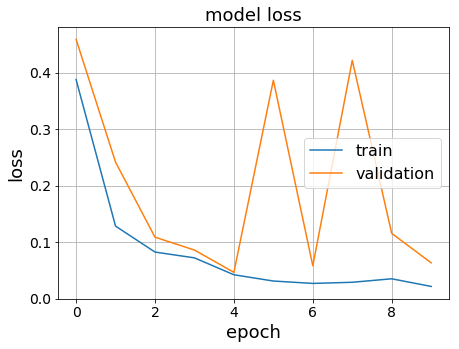

In [7]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)                                                                                                                                                                                               

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


## Show Results Compared to Truth

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


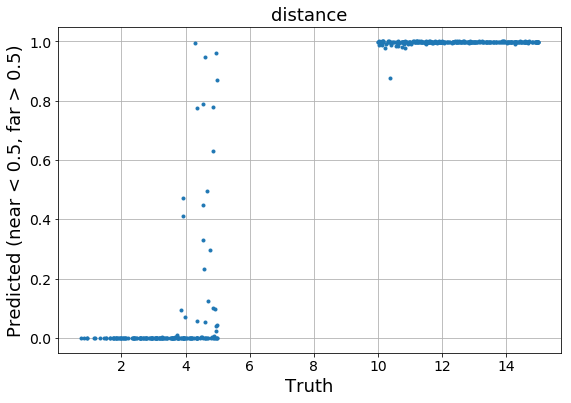

In [8]:
calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]

    data = get_input(row['filename'])

    values = model.predict(data[None,:])[0]

    calculated[ii] = values
    truth[ii] = row['distance']


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted (near < 0.5, far > 0.5)', fontsize=18)


In [9]:
indices_near = np.nonzero(truth <= 5)[0]
indices_far = np.nonzero(truth >= 10)[0]

# Far:  How many are predicted incorrectly?
print('Truth is far, predicted is near: {}'.format(np.sum(calculated[indices_far]<=0.5)))
print('Truth is near, predicted is far: {} ({:3.1f}%)'.format(np.sum(calculated[indices_near]>=0.5), np.sum(calculated[indices_near]>=0.5)/len(indices_near)*100))

Truth is far, predicted is near: 0
Truth is near, predicted is far: 8 (4.5%)


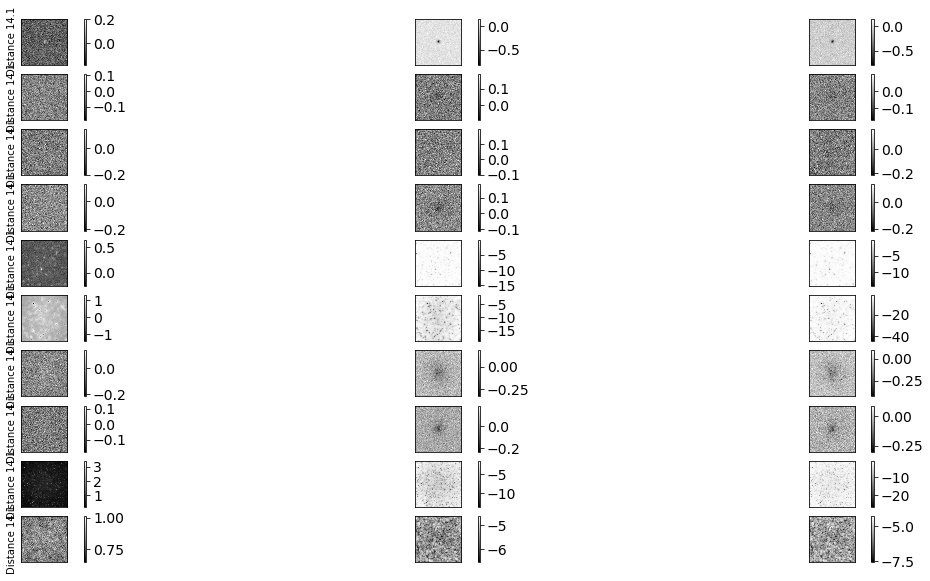

In [12]:
N = 10
plt.figure(figsize=[N*4, 10])
for ii, ti in enumerate(test_indices[:N]):
    data = get_input(dwarfs_table[ti]['filename'])

    sub_model = keras.Model(inputs=model.inputs, outputs=model.layers[1].output)

    prediction = sub_model.predict(data[None,:])

    plt.subplot(N,3,ii*3+1)
    plt.imshow(prediction[0,:,:,0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.ylabel('Distance {:3.1f}'.format(row['distance']))

    plt.subplot(N,3,ii*3+2)
    plt.imshow(prediction[0,:,:,1], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

    plt.subplot(N,3,ii*3+3)
    plt.imshow(prediction[0,:,:,2], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()


